# EM Field Prediction

*Scenario*:
An RF engineer is designing a microstrip antenna for 5G communication. They need to understand the electric field distribution around the antenna to optimize radiation patterns and ensure regulatory compliance. Traditional EM simulation (using tools like Keysight EMPro) takes 5-15 minutes per geometry configuration.

*Your Goal*:
Build an ML surrogate model that predicts the 2D electric field distribution around a simple antenna geometry in <100ms, with <10% error compared to the physics simulator.

*Input*: [L, W, x_pos, y_pos, V]

Where:
- L: antenna length (range: 0.01 to 0.2 meters)
- W: antenna width (range: 0.001 to 0.01 meters)  
- x_pos: x-position of antenna center (range: -0.1 to 0.1 m)
- y_pos: y-position of antenna center (range: -0.1 to 0.1 m)
- V: applied voltage (range: 1 to 100 volts)

*Output*: E_field on a 2D grid

Grid: 32x32 spatial points covering [-0.3, 0.3] m in both x and y
Each point: [Ex, Ey] (2 components)

Total output dimension: 32 x 32 x 2 = 2048 values

In [1]:
import numpy as np

def compute_dipole_field(L, x_pos, y_pos, V, grid_x, grid_y):
    """
    Compute dipole electric field on a 2D grid
    
    Parameters:
    -----------
    L : float
        Antenna length (meters)
    x_pos : float
        X-position of antenna center
    y_pos : float
        Y-position of antenna center
    V : float
        Applied voltage (volts)
    grid_x : ndarray (2D)
        X-coordinates of grid points (from meshgrid)
    grid_y : ndarray (2D)
        Y-coordinates of grid points (from meshgrid)
    
    Returns:
    --------
    Ex_total : ndarray (2D)
        X-component of electric field at each grid point
    Ey_total : ndarray (2D)
        Y-component of electric field at each grid point
    """
    
    # 1. CHARGE MAGNITUDE
    # Simplified model: Q ∝ V × L
    Q = V * L * 1e-11  # Changed from 1e-9 to get more reasonable field values
    
    # 2. CHARGE POSITIONS
    x_plus = x_pos         # X-position of positive charge
    y_plus = y_pos + L/2   # Y-position of positive charge (top)
    
    x_minus = x_pos        # X-position of negative charge
    y_minus = y_pos - L/2  # Y-position of negative charge (bottom)
    
    # 3. COULOMB'S CONSTANT
    k = 8.99e9  # More accurate value: N⋅m²/C²
    
    # 4. FIELD FROM POSITIVE CHARGE (+Q)
    # Vector from charge to grid points
    dx_plus = grid_x - x_plus  # Shape: (grid_size, grid_size)
    dy_plus = grid_y - y_plus
    
    # Distance from positive charge to each grid point
    r_plus = np.sqrt(dx_plus**2 + dy_plus**2)
    
    # Avoid division by zero (minimum distance threshold)
    r_plus = np.maximum(r_plus, 1e-6)  # Clamp to minimum value
    
    # Electric field components from positive charge
    # E = k*Q*(r - r_charge)/|r - r_charge|³
    Ex_plus = k * Q * dx_plus / (r_plus**3)
    Ey_plus = k * Q * dy_plus / (r_plus**3)
    
    # 5. FIELD FROM NEGATIVE CHARGE (-Q)
    # Vector from charge to grid points
    dx_minus = grid_x - x_minus
    dy_minus = grid_y - y_minus
    
    # Distance from negative charge to each grid point
    r_minus = np.sqrt(dx_minus**2 + dy_minus**2)
    r_minus = np.maximum(r_minus, 1e-6)
    
    # Electric field components from negative charge
    # Note: Charge is -Q (negative)
    Ex_minus = k * (-Q) * dx_minus / (r_minus**3)
    Ey_minus = k * (-Q) * dy_minus / (r_minus**3)
    
    # 6. SUPERPOSITION: Total field is sum of both
    Ex_total = Ex_plus + Ex_minus
    Ey_total = Ey_plus + Ey_minus
    
    return Ex_total, Ey_total

In [6]:
def divergence_loss(E_pred, grid_spacing=0.3/32):
    """
    Compute divergence loss: penalize ∇·E ≠ 0
    
    Args:
        E_pred: Predicted E-field (batch, 2, H, W) where 2 = [Ex, Ey]
        grid_spacing: Spatial resolution (meters per pixel)
    
    Returns:
        Divergence penalty (scalar)
    """
    
    # E_pred shape: (batch, 2, 32, 32)
    Ex = E_pred[:, 0, :, :]  # (batch, 32, 32)
    Ey = E_pred[:, 1, :, :]  # (batch, 32, 32)
    
    # Compute ∂Ex/∂x using central differences
    # Central difference: f'(x) ≈ (f(x+h) - f(x-h)) / (2h)
    
    # ∂Ex/∂x (derivative in x-direction)
    dEx_dx = (Ex[:, :, 2:] - Ex[:, :, :-2]) / (2 * grid_spacing)
    # Shape after slicing: (batch, 32, 30) - lost 2 pixels on x-edges
    
    # ∂Ey/∂y (derivative in y-direction)
    dEy_dy = (Ey[:, 2:, :] - Ey[:, :-2, :]) / (2 * grid_spacing)
    # Shape: (batch, 30, 32) - lost 2 pixels on y-edges
    
    # To add them, need same shape - crop to common interior
    # Take central 30x30 region from both
    dEx_dx_crop = dEx_dx[:, 1:-1, :]  # (batch, 30, 30)
    dEy_dy_crop = dEy_dy[:, :, 1:-1]  # (batch, 30, 30)
    
    # Divergence: ∇·E = ∂Ex/∂x + ∂Ey/∂y
    divergence = dEx_dx_crop + dEy_dy_crop  # (batch, 30, 30)
    
    # Physics says divergence should be zero (in vacuum, away from charges)
    # We penalize deviation from zero
    div_loss = (divergence ** 2).mean()
    
    return div_loss, divergence

In [3]:
import matplotlib.pyplot as plt

# Create grid
grid_size = 32
grid_range = 0.3
x = np.linspace(-grid_range, grid_range, grid_size)
y = np.linspace(-grid_range, grid_range, grid_size)
grid_x, grid_y = np.meshgrid(x, y)

# Test case: Antenna at origin
L = 0.1      # 10 cm
x_pos = 0.0
y_pos = 0.0
V = 10.0     # 10 volts

# Compute field
Ex, Ey = compute_dipole_field(L, x_pos, y_pos, V, grid_x, grid_y)

# Compute magnitude
E_mag = np.sqrt(Ex**2 + Ey**2)


In [4]:
Ex.shape, type(Ex)

E_field = np.stack([Ex, Ey], axis=0)
E_field = np.expand_dims(E_field, axis=0)

E_field.shape, type(E_field)

((1, 2, 32, 32), numpy.ndarray)

In [7]:
div_los, divergence = divergence_loss(E_field)

div_los, divergence

(np.float64(34328026.6096301),
 array([[[ 1.57810765e+00,  1.87662407e+00,  2.23173092e+00,
           2.65220514e+00,  3.14692736e+00,  3.72404144e+00,
           4.38953761e+00,  5.14498147e+00,  5.98409974e+00,
           6.88814994e+00,  7.82071053e+00,  8.72388938e+00,
           9.51950363e+00,  1.01189835e+01,  1.04426375e+01,
           1.04426375e+01,  1.01189835e+01,  9.51950363e+00,
           8.72388938e+00,  7.82071053e+00,  6.88814994e+00,
           5.98409974e+00,  5.14498147e+00,  4.38953761e+00,
           3.72404144e+00,  3.14692736e+00,  2.65220514e+00,
           2.23173092e+00,  1.87662407e+00,  1.57810765e+00],
         [ 1.74380376e+00,  2.09886052e+00,  2.52842074e+00,
           3.04634073e+00,  3.66767982e+00,  4.40789005e+00,
           5.28122919e+00,  6.29785766e+00,  7.45882130e+00,
           8.74807384e+00,  1.01215244e+01,  1.14957693e+01,
           1.27437574e+01,  1.37079918e+01,  1.42372964e+01,
           1.42372964e+01,  1.37079918e+01,  1.274375

In [4]:
tmp = Ex[:, :-2]

tmp

array([[ 1.77549708e-01,  1.95772932e-01,  2.14806527e-01,
         2.34167776e-01,  2.53138962e-01,  2.70717628e-01,
         2.85579774e-01,  2.96074005e-01,  3.00271035e-01,
         2.96095774e-01,  2.81563291e-01,  2.55118942e-01,
         2.16044332e-01,  1.64841114e-01,  1.03465323e-01,
         3.52867866e-02, -3.52867866e-02, -1.03465323e-01,
        -1.64841114e-01, -2.16044332e-01, -2.55118942e-01,
        -2.81563291e-01, -2.96095774e-01, -3.00271035e-01,
        -2.96074005e-01, -2.85579774e-01, -2.70717628e-01,
        -2.53138962e-01, -2.34167776e-01, -2.14806527e-01],
       [ 1.94649290e-01,  2.17034235e-01,  2.41005705e-01,
         2.66119136e-01,  2.91631054e-01,  3.16409333e-01,
         3.38847101e-01,  3.56804711e-01,  3.67618640e-01,
         3.68229262e-01,  3.55481621e-01,  3.26630066e-01,
         2.80014872e-01,  2.15778547e-01,  1.36386525e-01,
         4.66829885e-02, -4.66829885e-02, -1.36386525e-01,
        -2.15778547e-01, -2.80014872e-01, -3.26630066e-

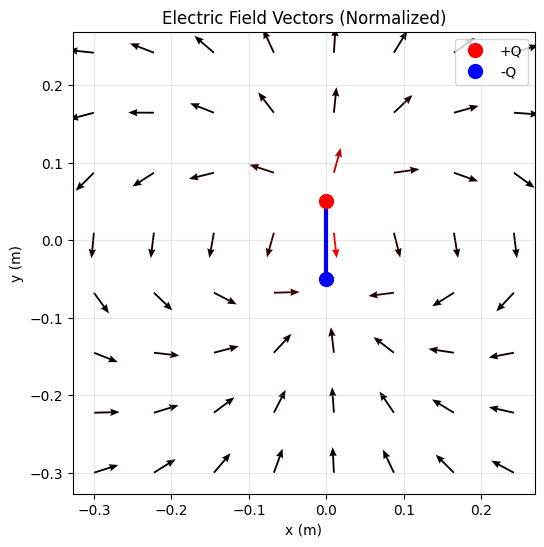

In [5]:
def plot_field_vectors(Ex, Ey, grid_x=grid_x, grid_y=grid_y,
                       x_pos=x_pos, y_pos=y_pos, L=L,
                       skip=4, cmap='hot', title='Electric Field Vectors (Normalized)'):
    """
    Plot normalized electric field vectors (quiver), colored by magnitude.
    Returns (fig, ax).
    """
    E_mag = np.sqrt(Ex**2 + Ey**2)
    Ex_norm = Ex / (E_mag + 1e-10)
    Ey_norm = Ey / (E_mag + 1e-10)

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.quiver(grid_x[::skip, ::skip], grid_y[::skip, ::skip],
              Ex_norm[::skip, ::skip], Ey_norm[::skip, ::skip],
              E_mag[::skip, ::skip],
              cmap=cmap,
              scale=None,
              scale_units='xy',
              angles='xy',
              width=0.004,
              headwidth=4,
              headlength=5)

    ax.plot([x_pos, x_pos], [y_pos - L/2, y_pos + L/2], 'b-', linewidth=3)
    ax.plot(x_pos, y_pos + L/2, 'ro', markersize=10, label='+Q', zorder=10)
    ax.plot(x_pos, y_pos - L/2, 'bo', markersize=10, label='-Q', zorder=10)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    return fig, ax

# Example usage
fig, ax = plot_field_vectors(Ex, Ey)
plt.show()

Now let's generate our dataset generating many points for different combinations of input features L, W, x_pos, y_pos, V, grid_x, grid_y

- L: antenna length (range: 0.01 to 0.2 meters)
- x_pos: x-position of antenna center (range: -0.1 to 0.1 m)
- y_pos: y-position of antenna center (range: -0.1 to 0.1 m)
- V: applied voltage (range: 1 to 100 volts)

In [6]:
l_bounds = [0.01, -0.1, -0.1, 1]
u_bounds = [0.2, 0.1, 0.1, 100]

from scipy.stats import qmc
from sqlalchemy import values
sampler = qmc.LatinHypercube(d=4)
sample = sampler.random(n=5000)

scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

In [7]:
scaled_sample.shape

(5000, 4)

In [8]:
import pandas as pd

inputs_df = pd.DataFrame(scaled_sample, columns=['L', 'x_pos', 'y_pos', 'V'])
inputs_df

,L,x_pos,y_pos,V
0,0.064970,-0.060343,0.083589,65.437860
1,0.055014,-0.033370,-0.007131,58.320568
2,0.182468,-0.008246,0.056258,35.463700
3,0.054244,-0.009768,0.024675,59.975488
4,0.172650,-0.072985,0.021399,50.750795
...,...,...,...,...
4995,0.083508,0.034479,-0.017703,82.357891
4996,0.083633,-0.018199,0.089583,76.581524
4997,0.188314,-0.036334,0.041628,94.839188
4998,0.076036,-0.007007,-0.073839,90.543740


In [9]:
inputs = inputs_df.to_numpy()
inputs

results = []

for L, x_pos, y_pos, V in inputs:
    Ex, Ey = compute_dipole_field(L, x_pos, y_pos, V, grid_x, grid_y)
    results.append((Ex, Ey))
    # Further processing can be done here

results[:2]  # Show first two results

[(array([[ 0.36495612,  0.37548862,  0.38153101, ..., -0.29352083,
          -0.27444382, -0.25559141],
         [ 0.41630387,  0.4321216 ,  0.44299845, ..., -0.32326965,
          -0.30000471, -0.27741007],
         [ 0.47532607,  0.49822326,  0.5158417 , ..., -0.35533444,
          -0.32714616, -0.30023389],
         ...,
         [-1.33498862, -1.60086993, -1.91624206, ...,  0.62989435,
           0.53223467,  0.45159235],
         [-1.22136865, -1.43481658, -1.67803217, ...,  0.61416206,
           0.52458464,  0.44940257],
         [-1.1017203 , -1.26942504, -1.45297768, ...,  0.58939044,
           0.50890352,  0.44021723]], shape=(32, 32)),
  array([[ 0.31035672,  0.36046785,  0.41490446, ...,  0.14968334,
           0.1230761 ,  0.10012784],
         [ 0.32687598,  0.38497798,  0.4490094 , ...,  0.14702822,
           0.11841663,  0.09408724],
         [ 0.34162474,  0.40886317,  0.48416651, ...,  0.14142194,
           0.11096753,  0.08547658],
         ...,
         [ 0.04228

In [10]:
results_array = np.array(results)
results_array.shape

(5000, 2, 32, 32)

In [11]:
# NumPy arrays don't have `permute` (that's a PyTorch method).
# Use transpose to reorder axes: (1000, 2, 32, 32) -> (1000, 32, 32, 2)
results_array = results_array.transpose(0, 2, 3, 1)
results_array.shape

(5000, 32, 32, 2)

In [12]:
results_array

array([[[[ 3.64956121e-01,  3.10356725e-01],
         [ 3.75488616e-01,  3.60467849e-01],
         [ 3.81531015e-01,  4.14904457e-01],
         ...,
         [-2.93520833e-01,  1.49683340e-01],
         [-2.74443823e-01,  1.23076099e-01],
         [-2.55591412e-01,  1.00127839e-01]],

        [[ 4.16303869e-01,  3.26875979e-01],
         [ 4.32121600e-01,  3.84977977e-01],
         [ 4.42998454e-01,  4.49009401e-01],
         ...,
         [-3.23269651e-01,  1.47028222e-01],
         [-3.00004711e-01,  1.18416629e-01],
         [-2.77410070e-01,  9.40872407e-02]],

        [[ 4.75326072e-01,  3.41624743e-01],
         [ 4.98223261e-01,  4.08863171e-01],
         [ 5.15841696e-01,  4.84166509e-01],
         ...,
         [-3.55334439e-01,  1.41421937e-01],
         [-3.27146160e-01,  1.10967529e-01],
         [-3.00233886e-01,  8.54765801e-02]],

        ...,

        [[-1.33498862e+00,  4.22861249e-02],
         [-1.60086993e+00,  1.75583651e-01],
         [-1.91624206e+00,  3.74882449

Now we can prepare the dataset for training a surrogate. Let's try to keep the output targets with dimension (batch, n1, n2, channels) so that we train a CNN (that looks like the best ML architecture for this problem where we have to predict a grid)

In [13]:
input_features = inputs_df.columns.tolist()
output_targets = results_array.copy()
targets_names = ["Ex", "Ey"]

In [14]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

input_tensor = torch.tensor(inputs_df.values, dtype=torch.float32)
output_tensor = torch.tensor(output_targets, dtype=torch.float32).permute(0, 3, 1, 2)

input_tensor.shape, output_tensor.shape

(torch.Size([5000, 4]), torch.Size([5000, 2, 32, 32]))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    input_tensor, output_tensor, test_size=0.15, random_state=42
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([4250, 4]),
 torch.Size([4250, 2, 32, 32]),
 torch.Size([750, 4]),
 torch.Size([750, 2, 32, 32]))

In [16]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = torch.tensor(X_scaler.fit_transform(X_train.numpy()), dtype=torch.float32)

Y_flat = y_train.reshape(y_train.shape[0], -1) # Keep batch dimension and flatten the others
y_train_scaled = y_scaler.fit_transform(Y_flat.numpy())
y_train_scaled = torch.tensor(y_train_scaled.reshape(y_train.shape), dtype=torch.float32)

X_val_scaled = torch.tensor(X_scaler.transform(X_val.numpy()), dtype=torch.float32)

Y_val_flat = y_val.reshape(y_val.shape[0], -1)
y_val_scaled = y_scaler.transform(Y_val_flat.numpy())
y_val_scaled = torch.tensor(y_val_scaled.reshape(y_val.shape), dtype=torch.float32)

X_train_scaled.shape, y_train_scaled.shape, X_val_scaled.shape, y_val_scaled.shape

(torch.Size([4250, 4]),
 torch.Size([4250, 2, 32, 32]),
 torch.Size([750, 4]),
 torch.Size([750, 2, 32, 32]))

In [17]:
type(X_train_scaled)

torch.Tensor

In [18]:
train_tensor = TensorDataset(X_train_scaled, y_train_scaled)
val_tensor = TensorDataset(X_val_scaled, y_val_scaled)

train_loader = DataLoader(train_tensor, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=32, shuffle=False)

In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
class SurrogateModel(nn.Module):
    def __init__(
            self,
            input_dim,
            latent_channels=64,
            latent_h=8,
            latent_w=8,
            output_channels=2,
            ):
        
        super().__init__()

        self.latent_channels = latent_channels
        self.latent_h = latent_h
        self.latent_w = latent_w
        self.latent_dimension = latent_channels * latent_h * latent_w

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dimension),
        )

        self.decoder = nn.Sequential(

            # (C, 8, 8) -> (32, 16, 16)
            nn.ConvTranspose2d(
                self.latent_channels,
                32,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.ReLU(),
            # (32, 16, 16) -> (16, 32, 32)
            nn.ConvTranspose2d(
                32,
                16,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.ReLU(),
            # (16, 32, 32) -> (output_channels, 32, 32)
            nn.Conv2d(
                16,
                output_channels,
                kernel_size=3,
                padding=1,
            ),
        )

    def forward(self, x):
        # x  : (batch_size, input_dim)
        batch_size = x.size(0)

        # Encode
        latent = self.encoder(x)

        # Reshape to (batch_size, C, H, W)
        latent = latent.view(
            batch_size,
            self.latent_channels,
            self.latent_h,
            self.latent_w,
        )

        # Decode to field
        output = self.decoder(latent)

        return output  # (batch_size, output_channels, 32, 32)


In [22]:
import torch.optim as optim
model = SurrogateModel(input_dim=len(input_features), latent_channels=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 200
physics_loss_weight = 0.0  # Weight for divergence loss

train_losses = []
train_data_losses = []
train_physics_losses = []
val_losses = []
val_data_losses = []
val_physics_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_data_loss = 0.0
    running_physics_loss = 0.0

    for inputs_batch, targets_batch in train_loader:
        inputs_batch = inputs_batch.to(device)
        targets_batch = targets_batch.to(device)

        optimizer.zero_grad()

        outputs_batch = model(inputs_batch)

        #physics_loss = divergence_loss(outputs_batch)
        data_loss = criterion(outputs_batch, targets_batch) 

        loss = data_loss # + physics_loss_weight * physics_loss

        loss.backward()
        optimizer.step()

        # Accumulate losses weighted by batch size
        batch_size = inputs_batch.size(0)
        running_train_loss += loss.item() * batch_size
        running_data_loss += data_loss.item() * batch_size
        #running_physics_loss += physics_loss.item() * batch_size

    n_train = len(train_loader.dataset)

    epoch_train_loss = running_train_loss / n_train
    epoch_data_loss = running_data_loss / n_train
    #epoch_physics_loss = running_physics_loss / n_train

    # Store
    train_losses.append(epoch_train_loss)
    train_data_losses.append(epoch_data_loss)
    #train_physics_losses.append(epoch_physics_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    running_val_data_loss = 0.0
    running_val_physics_loss = 0.0

    with torch.no_grad():
        for inputs_batch, targets_batch in val_loader:
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)

            outputs_batch = model(inputs_batch)

            # physics_loss_val = divergence_loss(outputs_batch)
            data_loss_val = criterion(outputs_batch, targets_batch)

            val_loss = data_loss_val #+ physics_loss_weight*physics_loss_val

            # Accumulate
            batch_size = inputs_batch.size(0)
            running_val_loss += val_loss.item() * batch_size
            running_val_data_loss += data_loss_val.item() * batch_size
            #running_val_physics_loss += physics_loss_val.item() * batch_size    

    # Average
    n_val = len(val_loader.dataset)
    epoch_val_loss = running_val_loss / n_val
    epoch_val_data = running_val_data_loss / n_val
    # epoch_val_physics = running_val_physics_loss / n_val

    # Accumulate
    val_losses.append(epoch_val_loss)
    val_data_losses.append(epoch_val_data)
    # val_physics_losses.append(epoch_val_physics)

    # -------- LOGGING --------
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(
            f"Epoch [{epoch+1:3d}/{num_epochs}] | "
            f"Train: {epoch_train_loss:.6f} "
            f"Val: {epoch_val_loss:.6f} "
             #  f"(data: {epoch_val_data:.6f}, phys: {epoch_val_physics:.6f})"
             #  f"(data: {epoch_data_loss:.6f}, phys: {epoch_physics_loss:.6f}) | "
        )

print("\n✓ Training complete!")

Epoch [  1/200] | Train: 0.035279 Val: 0.008273 
Epoch [ 10/200] | Train: 0.000292 Val: 0.005752 
Epoch [ 20/200] | Train: 0.000215 Val: 0.005674 
Epoch [ 30/200] | Train: 0.000178 Val: 0.005650 
Epoch [ 40/200] | Train: 0.000137 Val: 0.005694 
Epoch [ 50/200] | Train: 0.000135 Val: 0.005602 
Epoch [ 60/200] | Train: 0.000111 Val: 0.005584 
Epoch [ 70/200] | Train: 0.000104 Val: 0.005592 
Epoch [ 80/200] | Train: 0.000114 Val: 0.005580 
Epoch [ 90/200] | Train: 0.000101 Val: 0.005577 
Epoch [100/200] | Train: 0.000088 Val: 0.005598 
Epoch [110/200] | Train: 0.000085 Val: 0.005559 
Epoch [120/200] | Train: 0.000086 Val: 0.005564 
Epoch [130/200] | Train: 0.000080 Val: 0.005563 
Epoch [140/200] | Train: 0.000081 Val: 0.005574 
Epoch [150/200] | Train: 0.000078 Val: 0.005580 
Epoch [160/200] | Train: 0.000075 Val: 0.005560 
Epoch [170/200] | Train: 0.000072 Val: 0.005551 
Epoch [180/200] | Train: 0.000069 Val: 0.005550 
Epoch [190/200] | Train: 0.000067 Val: 0.005554 
Epoch [200/200] | Tr

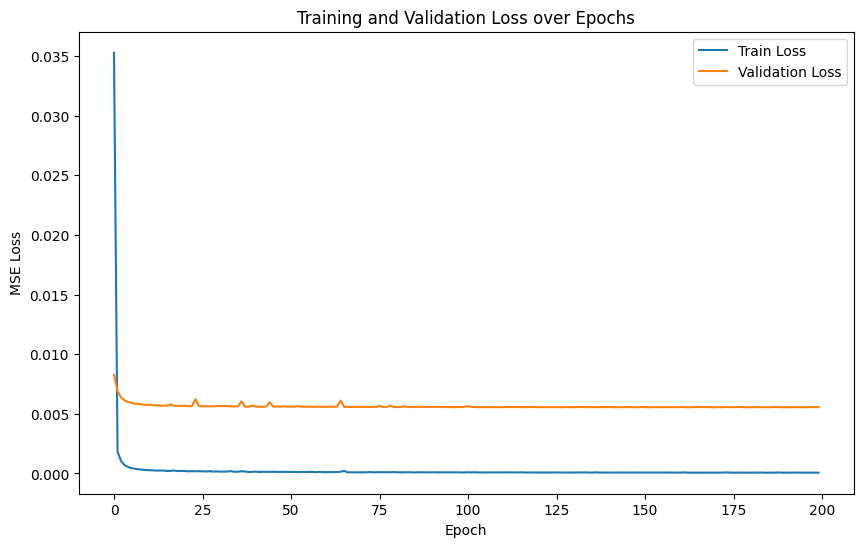

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')

plt.legend()
plt.show()

In [24]:
model.eval()
with torch.no_grad():
    sample_input = X_val_scaled[0:1].to(device)  # Take first sample from validation set
    predicted_output = model(sample_input)
    predicted_output = y_scaler.inverse_transform(
        predicted_output.cpu().numpy().reshape(1, -1)
    )
    predicted_output = predicted_output.reshape(1, 2, 32, 32)

target_output = y_val[0].cpu().numpy()

predicted_output=predicted_output.squeeze()
predicted_output.shape

Ex_pred = predicted_output[0]
Ey_pred = predicted_output[1]

In [25]:
sample_input_not_scaled = X_scaler.inverse_transform(sample_input.cpu())

sample_input_not_scaled

array([[ 8.39934041e-02, -8.62418411e-02,  8.84759046e-02,
         9.97610436e+01]])

In [26]:
L, x, y, V = sample_input_not_scaled[0]

L, x, y, V

(np.float64(0.0839934040709618),
 np.float64(-0.08624184112136793),
 np.float64(0.08847590462132122),
 np.float64(99.76104356438272))

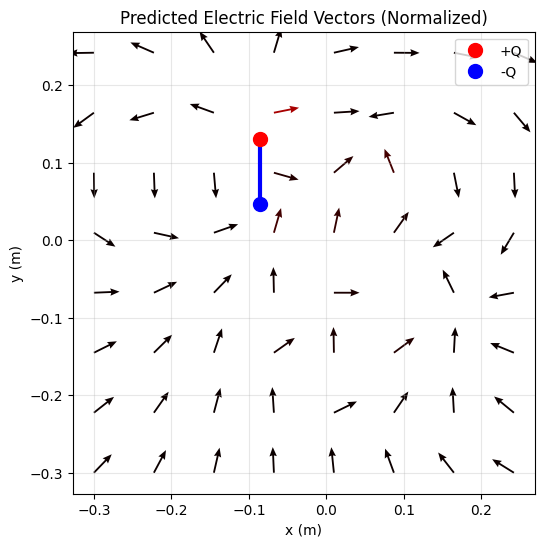

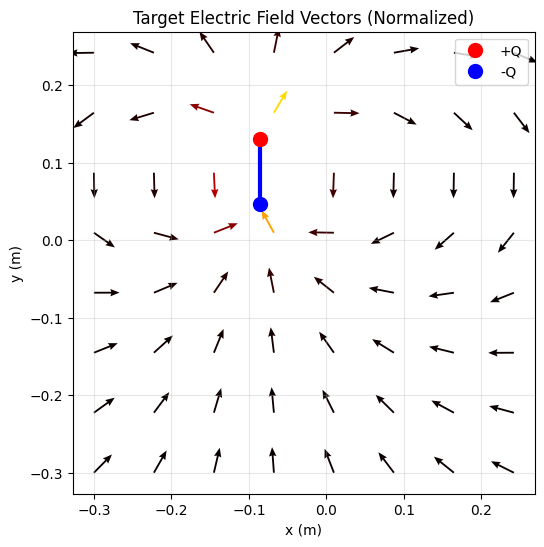

In [27]:
fig, ax = plot_field_vectors(Ex_pred, Ey_pred, x_pos=x, y_pos=y, L=L, title='Predicted Electric Field Vectors (Normalized)')
plt.show()

Ex_target = target_output[0]
Ey_target = target_output[1]

fig, ax = plot_field_vectors(Ex_target, Ey_target, x_pos=x, y_pos=y, L=L, title='Target Electric Field Vectors (Normalized)')
plt.show()

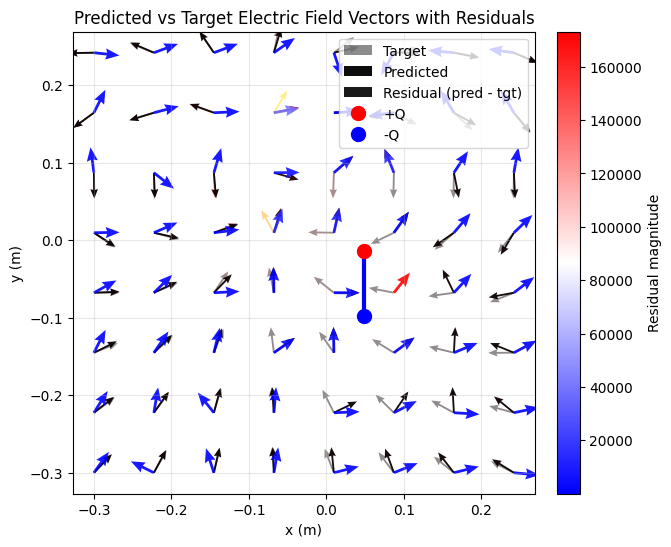

In [28]:
def plot_field_vectors(Ex, Ey, grid_x=grid_x, grid_y=grid_y,
                       x_pos=x_pos, y_pos=y_pos, L=L,
                       Ex_pred=None, Ey_pred=None, Ex_target=None, Ey_target=None,
                       skip=4, cmap='hot', cmap_diff='bwr', title='Electric Field Vectors (Normalized)'):
    """
    Plot normalized electric field vectors (quiver). Supports overlaying prediction vs target
    and showing the residuals (pred - target) colored by magnitude.

    Usage:
    - Single field (unchanged): plot_field_vectors(Ex, Ey, ...)
    - If Ex_pred & Ey_pred provided (and Ex_target/Ey_target omitted) -> Ex,Ey are treated as target and
      Ex_pred/Ey_pred as predicted via keyword args:
        plot_field_vectors(Ex_target, Ey_target, Ex_pred=Ex_pred, Ey_pred=Ey_pred, ...)
    - If Ex_pred & Ey_pred & Ex_target & Ey_target provided -> explicit pred/target plotting:
        plot_field_vectors(None, None, Ex_pred=..., Ey_pred=..., Ex_target=..., Ey_target=..., ...)
      (but usual convention is to pass the primary arrays positionally).
    Returns (fig, ax).
    """
    # Determine which arrays are present
    # Case A: both explicit provided
    if (Ex_pred is not None and Ey_pred is not None) and (Ex_target is not None and Ey_target is not None):
        pred_Ex, pred_Ey = Ex_pred, Ey_pred
        tgt_Ex, tgt_Ey = Ex_target, Ey_target
    # Case B: only Ex_pred passed (common pattern: positional Ex,Ey are prediction, target via keywords)
    elif (Ex_pred is not None and Ey_pred is not None) and (Ex_target is None and Ey_target is None):
        tgt_Ex, tgt_Ey = Ex, Ey
        pred_Ex, pred_Ey = Ex_pred, Ey_pred
    # Case C: only main arrays provided (single-field plot)
    else:
        pred_Ex, pred_Ey = None, None
        tgt_Ex, tgt_Ey = Ex, Ey

    fig, ax = plt.subplots(figsize=(7, 6))

    # Plot target (if present)
    if tgt_Ex is not None and tgt_Ey is not None:
        E_tgt_mag = np.sqrt(tgt_Ex**2 + tgt_Ey**2)
        Ex_tgt_n = tgt_Ex / (E_tgt_mag + 1e-10)
        Ey_tgt_n = tgt_Ey / (E_tgt_mag + 1e-10)

        q_tgt = ax.quiver(
            grid_x[::skip, ::skip], grid_y[::skip, ::skip],
            Ex_tgt_n[::skip, ::skip], Ey_tgt_n[::skip, ::skip],
            E_tgt_mag[::skip, ::skip],
            cmap=cmap,
            scale=None,
            scale_units='xy',
            angles='xy',
            width=0.004,
            headwidth=4,
            headlength=5,
            alpha=0.45,
            label='Target'
        )

    # Plot prediction (if present)
    if pred_Ex is not None and pred_Ey is not None:
        E_pred_mag = np.sqrt(pred_Ex**2 + pred_Ey**2)
        Ex_pred_n = pred_Ex / (E_pred_mag + 1e-10)
        Ey_pred_n = pred_Ey / (E_pred_mag + 1e-10)

        q_pred = ax.quiver(
            grid_x[::skip, ::skip], grid_y[::skip, ::skip],
            Ex_pred_n[::skip, ::skip], Ey_pred_n[::skip, ::skip],
            E_pred_mag[::skip, ::skip],
            cmap=cmap,
            scale=None,
            scale_units='xy',
            angles='xy',
            width=0.004,
            headwidth=4,
            headlength=5,
            alpha=0.95,
            label='Predicted'
        )

    # If both pred and target are present, plot residuals (pred - target)
    if (pred_Ex is not None and pred_Ey is not None) and (tgt_Ex is not None and tgt_Ey is not None):
        diff_x = pred_Ex - tgt_Ex
        diff_y = pred_Ey - tgt_Ey
        diff_mag = np.sqrt(diff_x**2 + diff_y**2)

        # Normalize residual vectors for visualization (so arrow direction is visible even for small mags)
        diff_nx = diff_x / (diff_mag + 1e-10)
        diff_ny = diff_y / (diff_mag + 1e-10)

        # Plot residual arrows; use a diverging colormap to highlight magnitude
        q_diff = ax.quiver(
            grid_x[::skip, ::skip], grid_y[::skip, ::skip],
            diff_nx[::skip, ::skip], diff_ny[::skip, ::skip],
            diff_mag[::skip, ::skip],
            cmap=cmap_diff,
            scale=None,
            scale_units='xy',
            angles='xy',
            width=0.006,
            headwidth=4,
            headlength=5,
            alpha=0.9,
            label='Residual (pred - tgt)'
        )

        # Colorbar for residual magnitude
        norm = plt.Normalize(vmin=diff_mag.min(), vmax=diff_mag.max())
        sm = plt.cm.ScalarMappable(cmap=cmap_diff, norm=norm)
        sm.set_array(diff_mag)
        cb = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cb.set_label('Residual magnitude')

    # Plot dipole geometry (same as before)
    ax.plot([x_pos, x_pos], [y_pos - L/2, y_pos + L/2], 'b-', linewidth=3)
    ax.plot(x_pos, y_pos + L/2, 'ro', markersize=10, label='+Q', zorder=10)
    ax.plot(x_pos, y_pos - L/2, 'bo', markersize=10, label='-Q', zorder=10)

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    return fig, ax

fig, ax = plot_field_vectors(Ex_pred, Ey_pred,
                           Ex_pred=Ex_pred, Ey_pred=Ey_pred,
                            Ex_target=Ex_target, Ey_target=Ey_target,
                            title='Predicted vs Target Electric Field Vectors with Residuals')
plt.show()